In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target

print(X.shape, y.shape)

(70000, 784) (70000,)


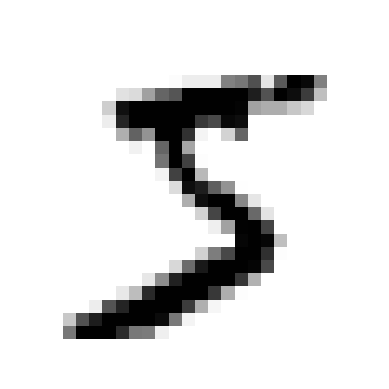

5


In [2]:
import matplotlib.pyplot as plt

def plot_digit(img_data):
    img = img_data.reshape((28, 28))
    
    plt.imshow(img, cmap='binary')
    plt.axis('off')

plot_digit(X[0])
plt.show()
print(y[0])

In [3]:
split_point = 60_000
X_tr, X_ts, y_tr, y_ts = X[:split_point], X[split_point:], y[:split_point], y[split_point:]

In [4]:
# binary classifier
y_tr_5 = (y_tr == '5')  # don't forget the quotes
y_ts_5 = (y_ts == '5')


from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_tr, y_tr_5)
sgd_clf.predict([X[0]])

array([ True])

In [5]:
from sklearn.model_selection import cross_val_score


cross_val_score(sgd_clf, X_tr, y_tr_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [6]:
# compare with this
from sklearn.dummy import DummyClassifier

dm_clf = DummyClassifier()
dm_clf.fit(X_tr, y_tr_5)

any(dm_clf.predict(X_tr))  # predicts 'Not 5' always

False

In [7]:
cross_val_score(dm_clf, X_tr, y_tr_5, cv=3, scoring='accuracy')  # also > 90% accuracy

array([0.90965, 0.90965, 0.90965])

In [8]:
# implementing CV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True)
for tr_idx, ts_idx in skfolds.split(X_tr, y_tr_5):
    clone_clf = clone(sgd_clf)

    X_tr_folds, X_ts_folds, y_tr_folds, y_ts_folds = X_tr[tr_idx], X_tr[ts_idx], y_tr_5[tr_idx], y_tr_5[ts_idx]

    clone_clf.fit(X_tr_folds, y_tr_folds)
    pred = clone_clf.predict(X_ts_folds)
    n_correct = sum(pred == y_ts_folds)

    print(n_correct / len(y_ts_folds))

0.95785
0.9615
0.9665


In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_tr_preds = cross_val_predict(sgd_clf, X_tr, y_tr_5, cv=3)  # returns preds instead of scores

confusion_matrix(y_tr_5, y_tr_preds)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

# now we can see our classifier isn't good
print(precision_score(y_tr_5, y_tr_preds))  # only correct 83% of the time it says it's a 5
print(recall_score(y_tr_5, y_tr_preds))  # only detects 65% of the 5s
print(f1_score(y_tr_5, y_tr_preds))  # low F1 cuz precision and recall aren't similar

0.8370879772350012
0.6511713705958311
0.7325171197343847


In [11]:
y_scores = cross_val_predict(sgd_clf, X_tr, y_tr_5, cv=3, method='decision_function')  # return scores instead of preds

from sklearn.metrics import precision_recall_curve
precs, recs, threshs = precision_recall_curve(y_tr_5, y_scores)  # plot the curve for all thresholds

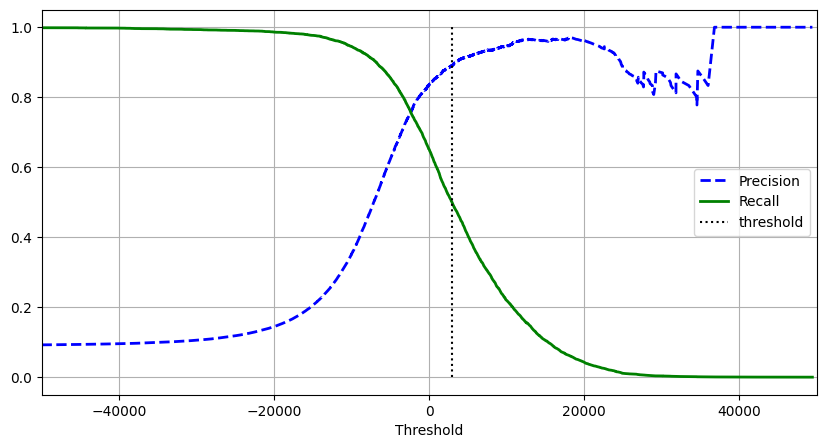

In [12]:
plt.figure(figsize=(10,5))

plt.plot(threshs, precs[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(threshs, recs[:-1], 'g-', label='Recall', linewidth=2)
thresh = 3000
plt.vlines(thresh, 0, 1.0, 'k', 'dotted', label='threshold')

plt.grid()
plt.legend()
plt.xlabel('Threshold')
plt.xlim(-50_000, 50_000)

plt.show()


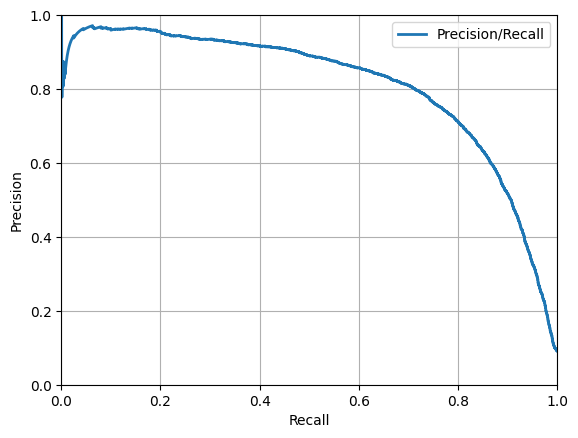

In [13]:
plt.plot(recs, precs, linewidth=2, label='Precision/Recall')

plt.grid()
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0., 1.0)
plt.ylim(0., 1.0)

plt.show()

In [14]:
# get threshold which gives required precision
wanted_prec = 0.90
idx = (precs >= 0.90).argmax()
wanted_thresh = threshs[idx]

print(wanted_thresh)

3370.0194991439557


In [15]:
# use it like so (call decision_function instead of predict)
y_tr_pred_90 = sgd_clf.decision_function(X_tr) >= wanted_thresh

In [16]:
print(precision_score(y_tr_5, y_tr_pred_90))
print(recall_score(y_tr_5, y_tr_pred_90))

0.9506477483035164
0.5685297915513743


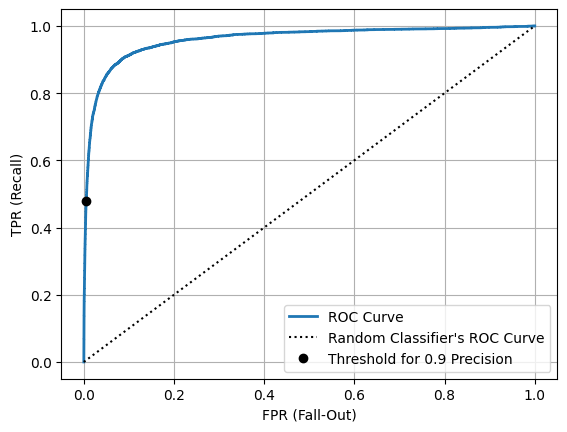

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, threshs = roc_curve(y_tr_5, y_scores)
idx = (threshs <= wanted_thresh).argmax()
tpr_90, fpr_90 = tpr[idx], fpr[idx]

plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k:', label="Random Classifier's ROC Curve")
plt.plot([fpr_90], [tpr_90], 'ko', label='Threshold for 0.9 Precision')

plt.grid()
plt.legend()
plt.xlabel('FPR (Fall-Out)')
plt.ylabel('TPR (Recall)')

plt.show()

In [18]:
# ROC AUC score helps comparing models
from sklearn.metrics import roc_auc_score

roc_auc_score(y_tr_5, y_scores)  # closer to 1.0 is good, greater than 0.5 (random classifier) is good

0.9604938554008616

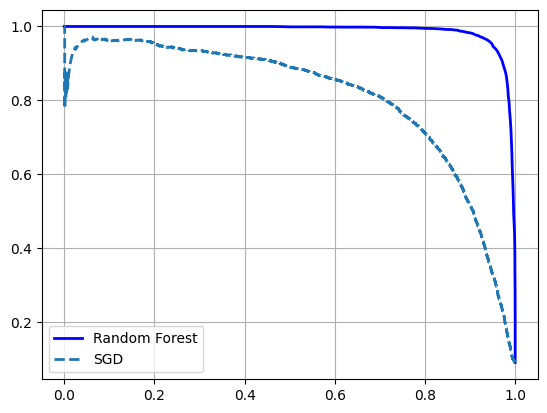

In [19]:
# try random forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

y_probas_rf = cross_val_predict(rf_clf, X_tr, y_tr_5, cv=3, method='predict_proba')

y_scores_rf_positive_class = y_probas_rf[:, 1]
precs_rf, recs_rf, threshs_rf = precision_recall_curve(y_tr_5, y_scores_rf_positive_class)

plt.plot(recs_rf, precs_rf, 'b-', linewidth=2, label='Random Forest')
plt.plot(recs, precs, '--', linewidth=2, label='SGD')

plt.grid()
plt.legend()

plt.show()

In [20]:
y_tr_preds_rf = y_probas_rf[:, 1] >= 0.5

print(f1_score(y_tr_5, y_tr_preds_rf))
print(roc_auc_score(y_tr_5, y_scores_rf_positive_class))

0.9274509803921569
0.9983436731328145


In [21]:
# multi-class classification
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_tr[:2000], y_tr[:2000])

print(svm_clf.predict([X[0]]))
scores = svm_clf.decision_function([X[0]])
print(scores.round(2))
class_id = scores.argmax()
print(class_id)

['5']
[[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]
5


In [22]:
print(svm_clf.classes_)
print(svm_clf.classes_[class_id])

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
5


In [23]:
# can force sklearn to use OVR or OVO like this
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_tr[:2000], y_tr[:2000])

print(ovr_clf.predict([X[0]]))
print(len(ovr_clf.estimators_))  # number of trained classifiers

['5']
10


In [24]:
# SGD can work with multiclass
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_tr, y_tr)

print(sgd_clf.predict([X[0]]))
print(sgd_clf.decision_function([X_tr[0]]).round())

['3']
[[-31893. -34420.  -9531.   1824. -22320.  -1386. -26189. -16148.  -4604.
  -12051.]]


In [25]:
# gets 85% on all test folds
# random classifier would get 10%
cross_val_score(sgd_clf, X_tr, y_tr, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [26]:
# improving the accuracy
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
X_tr_s = s.fit_transform(X_tr.astype('float64'))
cross_val_score(sgd_clf, X_tr_s, y_tr, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

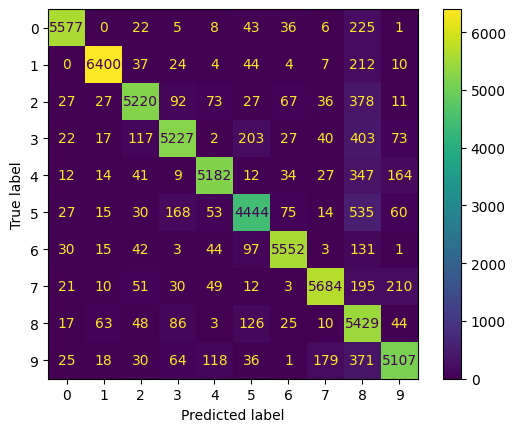

In [27]:
# Error analysis
from sklearn.metrics import ConfusionMatrixDisplay

y_tr_preds = cross_val_predict(sgd_clf, X_tr_s, y_tr, cv=3)

ConfusionMatrixDisplay.from_predictions(y_tr, y_tr_preds)
plt.show()

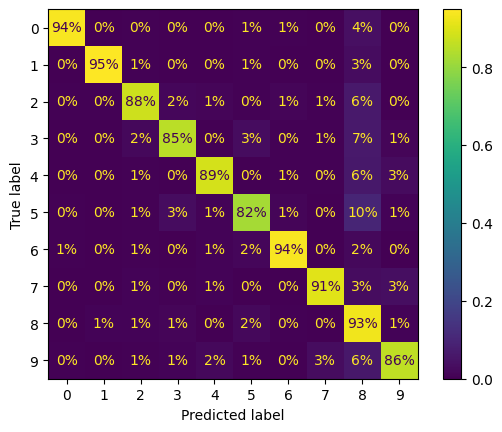

In [28]:
# it's important to normalize the matrix (divide by number of images for each class)
# e.g. in above, row and col 5 is darker, may be due to more errors on 5s or fewer 5s in the dataset
ConfusionMatrixDisplay.from_predictions(y_tr, y_tr_preds,
                                       normalize='true',  # divide by # of images of that class
                                       values_format='.0%')  # show % with no decimals
plt.show()

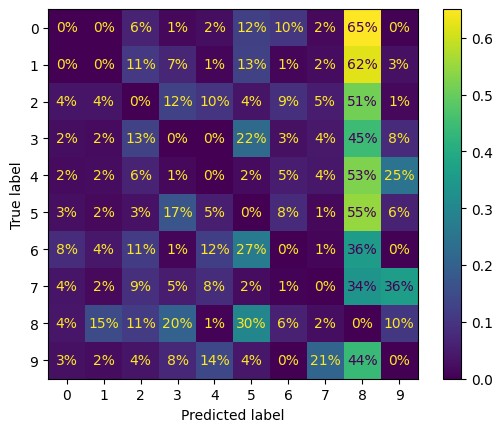

In [29]:
# above shows:
# - only 82% of 5s were classified correctly
# - most common error w/ 5s is misclassifying them as 8s
#   - happened for 10% of all 5s
# confusion matrices are generally not symmetrical (only 2% of 8s were misclassified as 5s)

# many were misclassified as 8s
# make this stand out using zero weight for correct predictions
sample_weight = (y_tr_preds != y_tr)
ConfusionMatrixDisplay.from_predictions(y_tr, y_tr_preds,
                                       sample_weight=sample_weight,
                                       normalize='true',
                                        values_format='.0%')
plt.show()

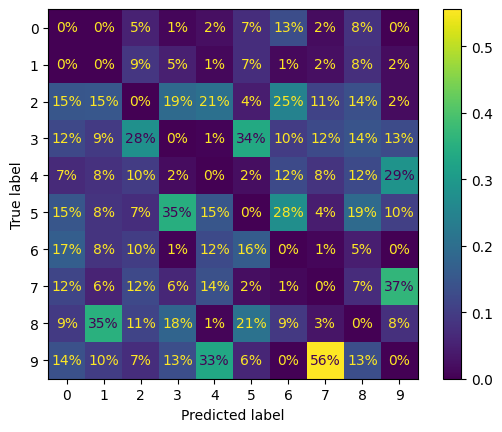

In [30]:
# need to be careful of interpretation:
# e.g. 36% in row 7 col 9 != 36% of 7s were misclassified as 9s
# it means 36% of *errors* on 7s were misclassifications as 9s
# only 3% of 7s were misclassified as 9s

# can normalize by col instead of row (normalize=pred)
ConfusionMatrixDisplay.from_predictions(y_tr, y_tr_preds,
                                       sample_weight=sample_weight,
                                       normalize='pred',
                                       values_format='.0%')
plt.show()
# e.g. 56% of misclassified 7s were 9s

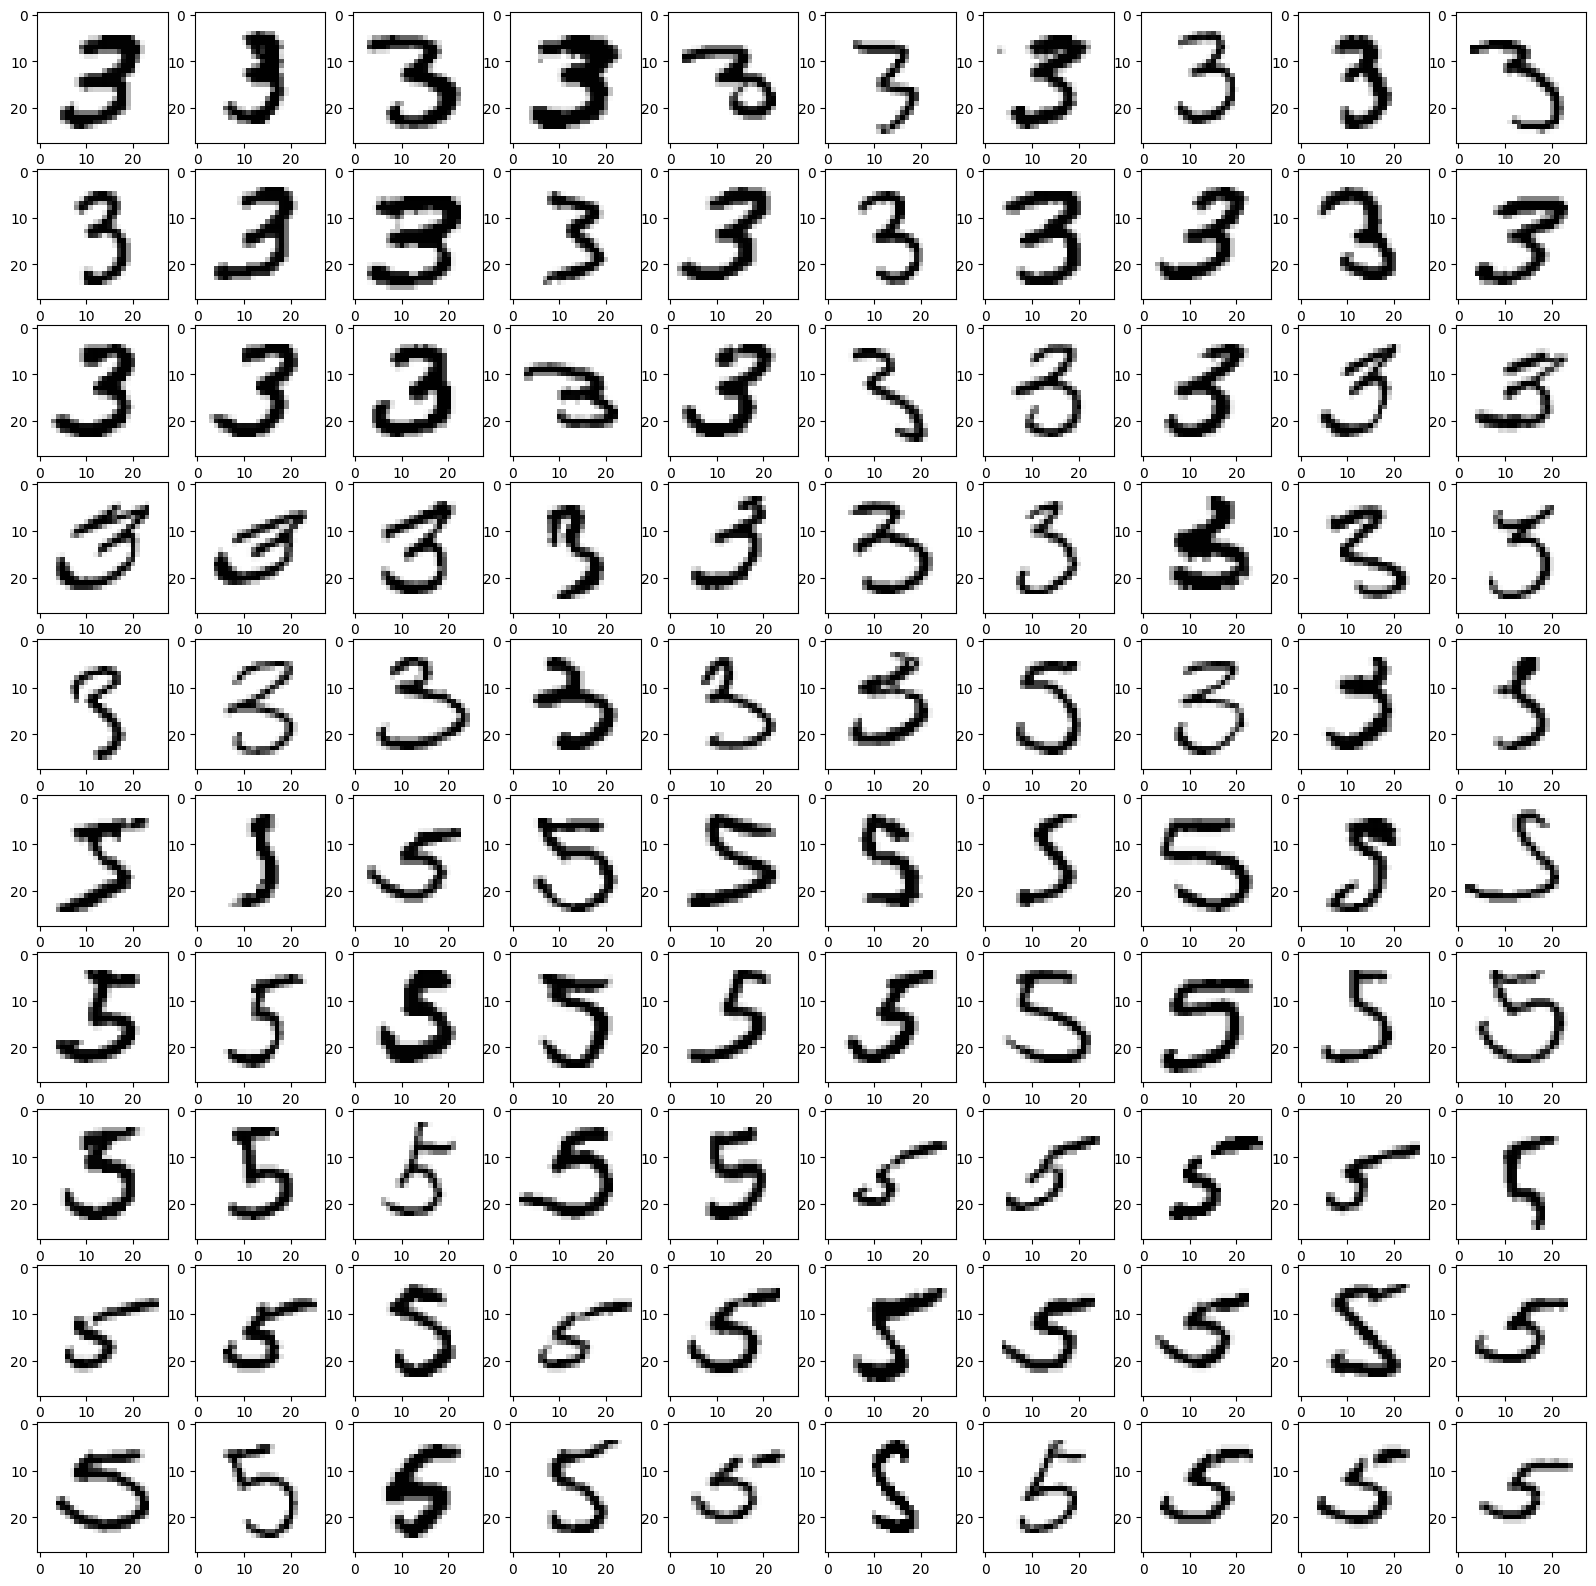

In [31]:
# check 3s and 5s
cl_a, cl_b = '3', '5'
X_aa = X_tr[(y_tr == cl_a) & (y_tr_preds == cl_a)]
X_ab = X_tr[(y_tr == cl_a) & (y_tr_preds == cl_b)]
X_ba = X_tr[(y_tr == cl_b) & (y_tr_preds == cl_a)]
X_bb = X_tr[(y_tr == cl_b) & (y_tr_preds == cl_b)]


f = plt.figure(figsize=(20,20))

rows = 5
cols = 5

from math import floor
for j, cur_imgs in zip(range(4), [X_aa, X_ab, X_ba, X_bb]):
   for i in range(0, rows * cols):
       img = cur_imgs[i]
    
       f.add_subplot(2 * rows, 2 * cols, i + (25 * j) +1)
       plt.imshow(img.reshape((28, 28)), cmap='binary')
 
plt.show()

In [34]:
# multi-label classification
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_tr_large = (y_tr >= '7')
y_tr_odd = (y_tr.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_tr_large, y_tr_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_tr, y_multilabel)

knn_clf.predict([X_tr[0]])

array([[False,  True]])

In [35]:
y_tr_knn_preds = cross_val_predict(knn_clf, X_tr, y_multilabel, cv=3)
# measure F1 on each individual label, then average -> assume all labels are equally important
print(f1_score(y_multilabel, y_tr_knn_preds, average='macro'))
# give weight according to each label's support (# instances with that label)
print(f1_score(y_multilabel, y_tr_knn_preds, average='weighted'))

0.9764102655606048

In [37]:
# some models don't support multilabel classification
# we can either train 1 model for each label but each model can't use info from the other models (e.g. large digit like 7,8,9 is twice more likely to be odd)
# or we can chain them (send inputs + predictions of prev model to next model)
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_tr[:2_000], y_multilabel[:2_000])

chain_clf.predict([X_tr[0]])

array([[0., 1.]])

In [39]:
# multioutput-multiclass (or simply multioutput) classification
# generalization of multilabel (each label can be multiclass)
# take noisy image and clean it, output is 1 label per px (multilabel) & each label can have 256 values

np.random.seed(42)

noise = np.random.randint(0, 100, (len(X_tr), 784))
X_tr_mod = X_tr + noise

noise = np.random.randint(0, 100, (len(X_ts), 784))
X_ts_mod = X_ts + noise

y_tr_mod = X_tr
y_ts_mod = X_ts

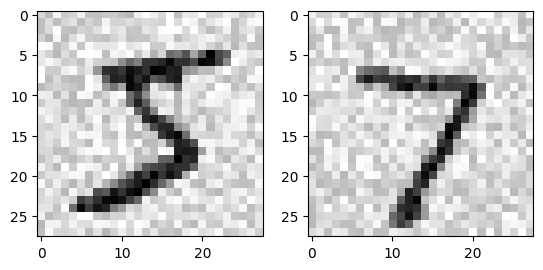

In [42]:
f = plt.figure()

f.add_subplot(1, 2, 1)
plt.imshow(X_tr_mod[0].reshape((28,28)), cmap='binary')

f.add_subplot(1, 2, 2)
plt.imshow(X_ts_mod[0].reshape((28,28)), cmap='binary')

plt.show()

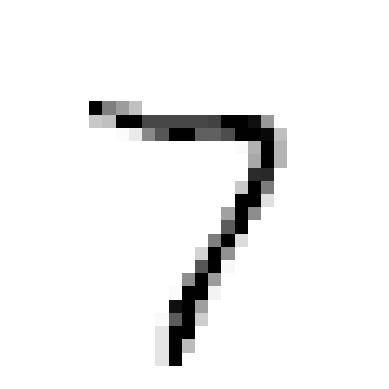

In [43]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_tr_mod, y_tr_mod)

clean_digit = knn_clf.predict([X_ts_mod[0]])

plot_digit(clean_digit)
plt.show()